In [4]:
import numpy as np
import xarray as xr
import xsimlab as xs
import numba #for wrapping the function
import zarr
import matplotlib.pyplot as plt
import sys
import os
%load_ext xsimlab.ipython
#plt.style.use('dark_background')

The xsimlab.ipython extension is already loaded. To reload it, use:
  %reload_ext xsimlab.ipython


In [5]:
#Compute the 1D uplift and subsidence curve using a modified approach from Duller et al. (2010) for applications of the Fedele and Paola (2007) grain size fining solution
#@numba.njit
def SubsidenceCurve_Duller_BatchF(alpha, u0, wm, wb, F, x, ts, tf, ntime):
    import xarray as xr
    fact = (1 - np.exp(-alpha))/alpha
    s0 = u0*wm/wb/fact/F
    ex=np.exp(-(x-wm)/wb*alpha)
    us = np.where(x<wm, 1, 0)
    u = np.where(x[np.newaxis,:,:]<wm, u0,-s0[:,np.newaxis,np.newaxis]*ex[np.newaxis,:,:])
    time = np.linspace(0,tf,ntime)
    u = xr.DataArray(u[:,np.newaxis,:, :] *np.where(time[np.newaxis,:,np.newaxis,np.newaxis]<ts, us[np.newaxis,np.newaxis,:,:], 1), dims=['F','time','y','x'])
    return u

In [21]:
#Run only once
os.chdir('..')
print(os.getcwd())

/Users/amandawild/Desktop/ClimateSignalPropagation_AlluvialFanGrainSize


In [22]:
from GravelScape_ModelPackages.GravelScape import GravelGSN

In [23]:
from ipyfastscape import TopoViz3d
#
from fastscape.models import sediment_model
#from fastscape.processes import Flexure
from fastscape.processes import FlowAccumulator
from fastscape.processes import (MultipleFlowRouter)
from fastscape.processes import (Bedrock)
from fastscape.processes import (DrainageArea)
#
#from fastscape.processes import StratigraphicHorizons
#sediment_model = sediment_model.update_processes({'drainage': FlowAccumulator}) # we change the drainage calculator to allow for non uniform rainfall
#sediment_model = sediment_model.update_processes({"flexure": Flexure}).drop_processes('init_topography')
model = sediment_model.update_processes({'flow': MultipleFlowRouter,
                                         'GravelGSN':GravelGSN,
                                         'bedrock':Bedrock,
                                         'drainage': FlowAccumulator,
                                         #'strati': StratigraphicHorizons,
                                        # "flexure": Flexure
                                        }).drop_processes('init_topography')


## Constant Variables

In [24]:
#Space and time

In [29]:
#constant Variables 
yl = 20e3#50e3#100e3#100e3 # yl, length of the mesh in the y-direction #1e3
ny = 41#51#101#101 # number of points in the y-direction #2
wm = 30e3#(xl/(nx-1))*25 # width of the mountain (in m) #cell size * number of cells

# time
time = np.linspace(0, 11e6, 1101)
#out = np.linspace(0, 30e6, 301)
tf = 11e6 # duration of the model run in years
ts = 2e6 # duration of the first phase of uplift without subsidence
ntime = 1101#5001 # number of time steps

In [30]:
#Other SPL

In [31]:
m = 0.5 # area exponent in the SPL
u0=0.0002#1e-2
alpha=2.5
n=1


## CHANGE: Variables that change to test different end members in the framework.

In [32]:
#INputs that cannot accept batch

In [33]:
#Basin area/confinement
#CHANGE THESE parameters to simulate constrained or unconstrained conditions.
xl = 45e3#45000 confined #75000 #unconfined # xl, length of the grid in the x-direction
nx = 91#91 confined #151 unconfined
wb = xl - wm # with of the basin (in m)
x, y = np.meshgrid(np.linspace(0,xl,nx), np.linspace(0,yl,ny)) # creates an x,y mesh
h0 = np.ones([ny,nx]) + np.where(x>wm,1-(x-wm)/(xl-wm), 1)

In [34]:
#Inputs where batch (multiple values are possible)

In [35]:
#Subsidence
#Change this to alternate a high and low bypass scenario
F = np.array([16]) #8 and 16 onwards
UpSubGrid=SubsidenceCurve_Duller_BatchF(alpha, u0, wm, wb, F, x, ts, tf, ntime)[0]

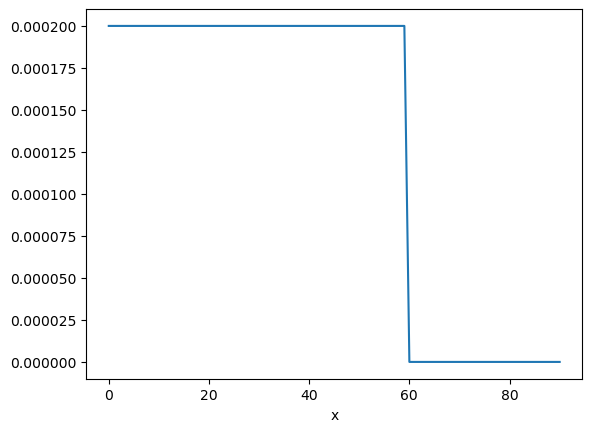

In [55]:
UpSubGrid.isel(time=1).mean('y').plot()

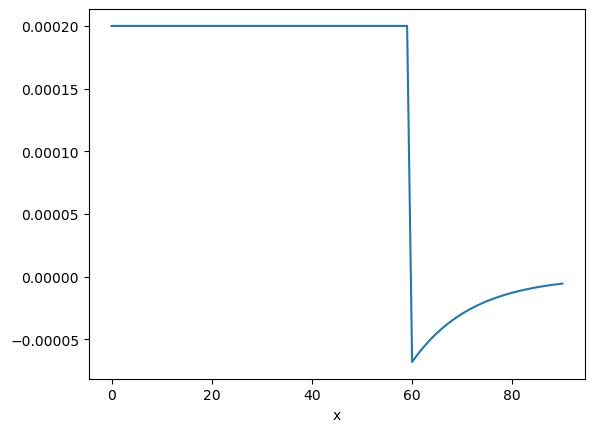

In [56]:
UpSubGrid.isel(time=-1).mean('y').plot()

In [37]:
# K and G
K=1e-6 #or 1e-5
#K=xr.DataArray(np.array([5e-5,2.5e-5,1e-5,7.5e-6,5e-6,2.5e-6,1e-6,7.5e-7,5e-7,2.5e-7,1e-7]),dims=['K'])#2.5e-7#12.5e-7
G=1#xr.DataArray([1,2])

## Impose a ten-fold change in Precipitaiton for 100kyr duration after 8Kyrs

In [38]:
#Precip
PrBasin=1
PrOrogen=1
pr = xr.DataArray(np.where(
    (x[np.newaxis,:, :]<wm)&
    (time[:,np.newaxis,np.newaxis] <=tf),
    PrOrogen,PrBasin),
                  dims=['time','y','x'])
precip=xr.DataArray(np.where(time[:,np.newaxis,np.newaxis]>8e6,pr*10,pr),dims=['time','y','x'])

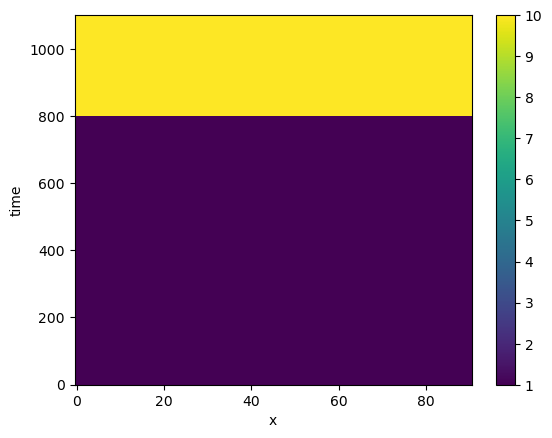

In [39]:
precip.mean('y').plot()

In [47]:
np.shape(UpSubGrid)

(1101, 41, 91)

In [52]:
np.shape(h0)

(41, 91)

In [53]:
np.shape(precip)

(1101, 41, 91)

In [50]:
np.shape(np.linspace(0,tf,ntime))
ny
nx

91

In [41]:
# %create_setup model --default --verbose
import xsimlab as xs

ds_in = xs.create_setup(
    model=model,
    clocks={'time': np.linspace(0,tf,ntime)},
    master_clock = 'time',
    input_vars={
        # nb. of grid nodes in (y, x)
        'grid__shape': [ny,nx],
        # total grid length in (y, x)
        'grid__length': [yl,xl],
        # node status at borders
        'boundary__status': ['core','fixed_value','looped','looped'],
        # uplift rate
        #'uplift__rate': SubsidenceCurve_Duller(alpha, u0Start, wm, wb, F, x, ts, tf, ntime),
        'uplift__rate': UpSubGrid,
        # random seed
        #'init_topography__seed': None,
         # initial topography
        "topography__elevation": h0,
        # MFD partioner slope exponent
        'flow__slope_exp': n,
        # drainage area exponent
        'spl__area_exp': m,
        # slope exponent
        'spl__slope_exp': n,
        # bedrock channel incision coefficient
        'spl__k_coef_bedrock': K ,#2e-5,
        # soil (sediment) channel ncision coefficient
        'spl__k_coef_soil': K, #1e-5,
        #
        'spl__tol_rel':10e-6,
        #
        'spl__tol_abs':0.0001,
        #
        'spl__max_iter':100,
        # drainage area exponent
        # detached bedrock transport/deposition coefficient
        'spl__g_coef_bedrock': G,
        # soil (sediment) transport/deposition coefficient
        'spl__g_coef_soil': G,
        # bedrock diffusivity
        'diffusion__diffusivity_bedrock':0 , #0.03,
        # soil (sediment) diffusivity
        'diffusion__diffusivity_soil': 0 ,#0.1,
        # The bedrock source D50 grain size
        'GravelGSN__D0': 1,
        # The bedrock source grain size standard deviation
        'GravelGSN__SD0': 0.75,
        # Cv (grain size calculation constant) described in Fedele and Paola (2007) and Duller
        # et al. (2010)
        'GravelGSN__Cv': 0.75,
        # C1 (grain size calculation constant) described in Fedele and Paola (2007) and Duller
        # et al. (2010)
        'GravelGSN__C1': 0.75,
        # Porosity
        'GravelGSN__porosity': 0,
        # runoff
        'drainage__runoff': precip,
        #'strati__freeze_time': np.linspace(0,tf,int((tf/((tf-Tsteady)/25))+1)),

    },
    output_vars={'topography__elevation': 'time', #multi time step
                'drainage__flowacc': 'time', #For mobility calculation over time
                #'flow__nb_donors': 'out2', #For longest river calc.
                #'flow__donors': 'out2', #For longest river calc.
                #'flow__nb_receivers':'out2',
                #'flow__receivers':'out2',
                #'flow__stack':'out2',
                #'GravelGSN__D0Source': 'out2', #time step specific GS
                'GravelGSN__DMean': 'time', #time step specific GS
                'GravelGSN__DTIME': 'time',
                #'GravelGSN__YStar':'out2',
                #'GravelGSN__EFlux': 'out2',
                'bedrock__elevation': 'time',
                #'flow__basin':'out2',
                'erosion__rate': 'time',
                #"strati__elevation": "out"
                }
)

/opt/anaconda3/envs/FastScapeEnvironment/lib/python3.10/site-packages/xsimlab/xr_accessor.py:229: FutureWarning: variable 'time' with name matching its dimension will not be automatically converted into an `IndexVariable` object in the future.
  xr_var = as_variable(data, name=dim)


In [57]:
os.chdir('Part1_GeneralFramework')
print(os.getcwd())

/Users/amandawild/Desktop/ClimateSignalPropagation_AlluvialFanGrainSize/Part1_GeneralFramework


In [58]:
# Example variables
# Create a filename using concatenation
filename = "GeneralFastscapePR10MagIncrease_"+"Confinedwb" + str(round(wb))+"_F" + str(F[0])+"_K" + str((K)) + "_G" + str(G) + ".zarr"
print(filename)

GeneralFastscapePR10MagIncrease_Confinedwb15000_F16_K1e-06_G1.zarr


In [59]:
zgroup = zarr.group(filename, overwrite=True)

In [44]:
#from dask.distributed import Client
#client = Client(n_workers=3, threads_per_worker=1)

In [45]:
#from dask.diagnostics import ProgressBar
#with model, ProgressBar():
    #ds_out = (ds_in
#              #.stack(batch=['Precip','F']) # you only need these lines when stacking multiple variables
              #.xsimlab.run(batch_dim='K',check_dims='transpose', parallel=True,scheduler=client,store=zgroup) #scheduler='processes'
#              #.unstack('batch')
              #)

In [46]:
with model, xs.monitoring.ProgressBar():
    ds_out = (ds_in.xsimlab.run(model=model, store=zgroup))

             0% | initialize 

ValueError: input operand has more dimensions than allowed by the axis remapping